<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Первый-взгляд-на-датасет" data-toc-modified-id="Первый-взгляд-на-датасет-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Первый взгляд на датасет</a></span></li><li><span><a href="#Обработка-текста" data-toc-modified-id="Обработка-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обработка текста</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Ресэмплинг" data-toc-modified-id="Ресэмплинг-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Ресэмплинг</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Лучшая-модель" data-toc-modified-id="Лучшая-модель-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Лучшая модель</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy


import lightgbm as lgb
from lightgbm import LGBMClassifier
from time import time
import catboost
from catboost import CatBoostClassifier
from pprint import pprint
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, auc
nltk.download('stopwords')
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
import numpy as np
RANDOM = 12345
from sklearn.model_selection import RandomizedSearchCV
import torch
import transformers
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
nlp = spacy.load("en_core_web_sm")
import requests

### Первый взгляд на датасет

In [2]:
pth1 = 'toxic_comments.csv' 
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1): df = pd.read_csv(pth1) 
elif os.path.exists(pth2): df = pd.read_csv(pth2) 
else: print('Something is wrong')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
df.head(6)

,Unnamed: 0,text,toxic
0,0,Explanation\r\nWhy the edits made under my use...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\r\n\r\nCongratulations from me as well, use ...",0


    Необходимо очистить текст от различных символов.

    Посмотрим на распределение классов.

In [5]:
df['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

<Axes: xlabel='toxic', ylabel='count'>

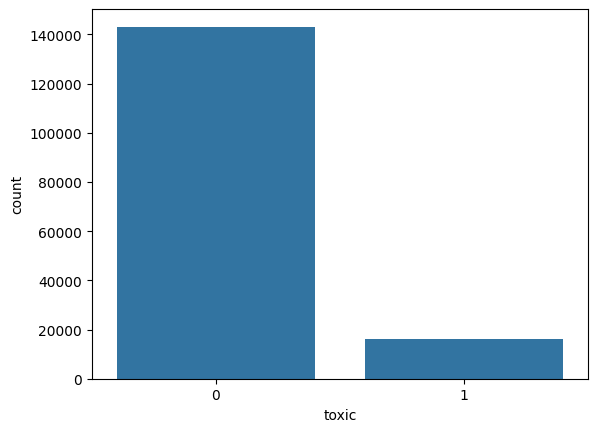

In [6]:
sns.countplot(x=df['toxic'])

    Дисбаланс классов налицо.
    
    
    При разделении выборок нужно будет применить стратификацию по таргету, в  моделях балансировать веса и, скорее всего, ресемплировать выборку. 

### Обработка текста

Функция обработки текста.

In [7]:
del_n = re.compile('\n')                  # перенос каретки
del_tags = re.compile('<[^>]*>')          # html-теги
del_brackets = re.compile('\([^)]*\)')    # содержимое круглых скобок
clean_text = re.compile('[^а-яa-z\s]')    # все небуквенные символы кроме пробелов
del_spaces = re.compile('\s{2,}')         

def prepare_text(text):
    text = del_n.sub(' ', str(text).lower())
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)
    res_text = clean_text.sub('', text)
    res_text = res_text.lower()  #перевод в нижний регистр
    return del_spaces.sub(' ',res_text)

Функция удаления стоп-слов, внутри которой будет задействована предыдущая функция.

In [8]:
stop = set(nltk_stopwords.words('english') + ["im", "ill", "oh", "hey"])

In [9]:
def df_stop_words(Sr, stop):
    Sr_2 = Sr.copy()
    for itm in range(len(Sr)):
        line = Sr_2[itm]
        line = prepare_text(line) # функция обработки текста (см. выше)
        line = [w for w in line.split() if w not in stop] # удаление стоп-слов
        line = " ".join(line)
        line = nlp(line)
        line = " ".join([token.lemma_ for token in line]) # лемматизация
        Sr_2[itm] = line
    return Sr_2

Применяю их к датасету, создаю новый столбец.

In [10]:
df['text_clr'] = df_stop_words(df['text'], stop)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
 3   text_clr    159292 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.9+ MB


In [12]:
df.head(6)

,Unnamed: 0,text,toxic,text_clr
0,0,Explanation\r\nWhy the edits made under my use...,0,explanation edit make username hardcore metall...
1,1,D'aww! He matches this background colour I'm s...,0,daww match background colour seemingly stick t...
2,2,"Hey man, I'm really not trying to edit war. It...",0,man really try edit war guy constantly remove ...
3,3,"""\r\nMore\r\nI can't make any real suggestions...",0,ca nt make real suggestion improvement wonder ...
4,4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page that s
5,5,"""\r\n\r\nCongratulations from me as well, use ...",0,congratulation well use tool well talk


### Разделение на выборки

В качестве целевого признака идёт столбец "toxic", а за фичи возьму столбец "text_clr".

In [13]:
features = df['text_clr']
target = df['toxic']

Делю на обучающую и тестовую в отношении 70:30, учитывая дисбаланс с помощью стратификации.

In [14]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=RANDOM, stratify=target)

In [15]:
print(f'features_train shape: {features_train.shape}\ntarget_train shape: {target_train.shape} \nfeatures_test shape: {features_test.shape} \ntarget_test shape: {target_test.shape}') 

features_train shape: (111504,)
target_train shape: (111504,) 
features_test shape: (47788,) 
target_test shape: (47788,)


### Ресэмплинг

Теперь займусь преобразованием сета.
Чтобы не было утечки данных во время кросс-валидации, использую только downsample.


In [16]:
df_ = df.iloc[target_train.index]

In [17]:
df_

,Unnamed: 0,text,toxic,text_clr
21863,21883,Good god the power you have must be ORGASMIC!!!,1,good god power must orgasmic
60362,60428,Brutal force is your ultimate argument. Keep p...,0,brutal force ultimate argument keep pervert
8214,8226,RE: Juarez \r\num no you get over it get a life,0,juarez um get get life
119947,120052,"""* In the Infobox remove any information for t...",0,infobox remove information style parameter exc...
52007,52064,Why oppose your own nomination? You can just w...,0,oppose nomination withdraw
...,...,...,...,...
87153,87234,yahoo mail \r\n\r\nHello,0,yahoo mail hello
54715,54776,"""\r\n\r\nIndeed BigDunc, that page rightly say...",0,indeed bigdunc page rightly say paramilitary n...
71196,71266,Forgive my cruddy formattingI'm still relative...,0,forgive cruddy formattingim still relatively new
55751,55812,"""\r\n\r\n Talk:Grasshopper Scouts \r\n\r\nI mo...",0,talkgrasshopper scout move comment talkgrassho...


In [18]:
target_train_zero = df_[df_['toxic'] == 0]['toxic']

In [19]:
target_train_one = df_[df_['toxic'] == 1]['toxic']

In [20]:
len(target_train_zero)

100174

In [21]:
len(target_train_one)

11330

Как и было, дисбаланс.

In [22]:
target_train_zero_min = target_train_zero.sample(target_train_one.shape[0], random_state=RANDOM)

In [23]:
target_train_min = pd.concat([target_train_zero_min, target_train_one])

In [24]:
target_train_min = target_train_min.sample(frac=1)

In [25]:
features_train_min = df_.loc[target_train_min.index]['text_clr']

In [26]:
print(f'features_train_min shape: {features_train_min.shape}\ntarget_train_min shape: {target_train_min.shape}') 


features_train_min shape: (22660,)
target_train_min shape: (22660,)


## Обучение

Создаю таблицу для сбора результатов.


In [27]:
rating_table = pd.DataFrame(columns=['f1_best_cv', 'f1_test',  'ROC-AUC_test', 'time_cvs'])
rating_table

def add_line_df_score(df_score, model, f1_best_cv,  f1_test, rocauc_score, time_cvs):
    
    df_score.loc[model, 'f1_best_cv'] = "{:.2%}".format(f1_test)
    df_score.loc[model, 'f1_test'] = "{:.2%}".format(f1_best_cv)
    df_score.loc[model, 'ROC-AUC_test'] = "{:.2%}".format(rocauc_score) 
    df_score.loc[model, 'time_cvs'] = "{:.2}".format(time_cvs) 
    
    return df_score

Теперь для функции просчёта метрик создаю наборы данных.

In [28]:
estimators = [LogisticRegression(random_state=RANDOM, n_jobs=1, class_weight={0 : 1, 1: 8}), 
              #LogisticRegression(random_state=RANDOM, n_jobs=1),
              ComplementNB(class_prior = (1,8)),
              #ComplementNB(),
              CatBoostClassifier(random_state=RANDOM, class_weights = (1, 8)),
              #CatBoostClassifier(random_state=RANDOM),
              LGBMClassifier(seed=RANDOM, verbose = -1, device = "gpu", scale_pos_weight=8),
              #LGBMClassifier(seed=RANDOM, verbose = -1, device = "gpu")              
             ]

est_names = ['LogisticRegression_balanced_weights',
            #'LogisticRegression_balanced_set',
            'ComplementNB_balanced_weights',
            #'ComplementNB_balanced_set',
            'CatBoostClassifier_balanced_weights',
            #'CatBoostClassifier_balanced_set',
            'LGBMClassifier_balanced_weights',
            #'LGBMClassifier_balanced_set'             
            ]


param_lr = {'clf__penalty': ['l1','l2'],               
              'clf__solver': ['lbfgs', 'newton-cg'],              
              'clf__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 10, 100]}
param_cat = {'clf__n_estimators': (1, 100, 10),
                  'clf__max_depth' : (1, 100, 10),
                  'clf__l2_leaf_reg': (1, 50, 10)}             
param_lgbm = {
    'clf__max_depth': range(4,100),
    'clf__n_estimators': range(1,200)
}
param_cnb = {"clf__alpha": np.logspace(-6, 6, 13)}

est_param_grids = [
    param_lr,
    #param_lr,
    param_cnb,
    #param_cnb,
    param_cat,
    #param_cat,
    param_lgbm,
    #param_lgbm    
]

Теперь объявляю функцию для векторизации, моделирования, обучения с использованием кросс-валидации и тестирования лучших моделей. Результаты собираю в таблицу.

In [29]:
def modelling(estimator, estimator_name, est_param_grid, df_score):

    print('\n_______________________\n', estimator_name, '\n_______________________\n')
    pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", estimator)
    ]
    )
    
    parameter_grid = {
        #"vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
        #"vect__min_df": (1, 3, 5, 10),
        #"vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
        #"vect__norm": ("l1", "l2")
    }
    
    parameter_grid.update(est_param_grid) 
    
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=parameter_grid,
        n_iter=40,
        random_state=RANDOM,
        scoring='f1',
        n_jobs=2,
        verbose=1,
    )
    
    print("Performing grid search...")
    print("Hyperparameters to be evaluated:")
    print(parameter_grid)

    t0 = time()

    random_search.fit(features_train_balance, target_train_balance)
    done_time=time() - t0
    print(f"Done in {done_time:.3f}s")

    print("\n\nBest parameters combination found:")
    best_parameters = random_search.best_estimator_.get_params()
    for param_name in sorted(parameter_grid.keys()):
        print(f"{param_name}: {best_parameters[param_name]}")

    test_f1 = random_search.score(features_test, target_test)
    f1_best_cv = random_search.best_score_
    print(
        "\n\nF1 of the best parameters using the inner CV of "
        f"the random search: {f1_best_cv:.3f}"
    )
    print(f"F1 on test set: {test_f1:.3f}")
    rocauc_score = roc_auc_score(target_test, random_search.predict(features_test))
    print(f'\nRoс_auc on test: {rocauc_score:.3f}\n\n')

    
    add_line_df_score(df_score, estimator_name, f1_best_cv, test_f1, rocauc_score, done_time)

    return df_score

Поскольку я хочу использовать два типа сетов - сбалансированный и как есть, я предлагаю выбор исходников в зависимости от индекса, потому что на чётных индексах я расположила модели с учётом баланса весов, а на нечётных позициях без балансировки весов, потому что у них балансированные входящие данные.

In [30]:
for i in range(len(estimators)):
    #if i%2 != 0:
    features_train_balance = features_train
    target_train_balance = target_train
    #else:
    #    features_train_balance = features_train_min
    #    target_train_balance = target_train_min
    rating_table = modelling(estimators[i], est_names[i], est_param_grids[i], rating_table)
    



_______________________
 LogisticRegression_balanced_weights 
_______________________

Performing grid search...
Hyperparameters to be evaluated:
{'clf__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 10, 100],
 'clf__penalty': ['l1', 'l2'],
 'clf__solver': ['lbfgs', 'newton-cg']}
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Done in 265.016s


Best parameters combination found:
clf__C: 10
clf__penalty: l2
clf__solver: newton-cg


F1 of the best parameters using the inner CV of the random search: 0.759
F1 on test set: 0.763

Roс_auc on test: 0.882


{'ok': True, 'result': {'message_id': 376, 'from': {'id': 6015117129, 'is_bot': True, 'first_name': 'hi_from_jup', 'username': 'hi_from_jup_bot'}, 'chat': {'id': 916785354, 'first_name': 'Maria', 'username': 'maria_smiles', 'type': 'private'}, 'date': 1697204527, 'text': 'count_i'}}

_______________________
 ComplementNB_balanced_weights 
_______________________

Performing grid search...
Hyperparameters to be eva

In [31]:
rating_table

,f1_best_cv,f1_test,ROC-AUC_test,time_cvs
LogisticRegression_balanced_weights,76.26%,75.88%,88.24%,2.7e+02
ComplementNB_balanced_weights,67.05%,66.86%,86.65%,6.5e+01
CatBoostClassifier_balanced_weights,70.52%,71.12%,82.40%,7.8e+03
LGBMClassifier_balanced_weights,75.41%,75.64%,87.52%,1.1e+03


### Лучшая модель

Лучше всего себя показала логистическая регрессия.

In [32]:
tf_converter = TfidfVectorizer()
tf_idf_train = tf_converter.fit_transform(features_train)
tf_idf_test = tf_converter.transform(features_test)

In [33]:
best_model = LogisticRegression(random_state=RANDOM, n_jobs=1, C=10, penalty='l2', solver='lbfgs', class_weight={0 : 1, 1: 8})
best_model.fit(tf_idf_train, target_train)
predict_best = best_model.predict(tf_idf_test)

In [34]:
print(f'Метрика F1 на обучающих данных = {"{:.2%}".format(f1_score(target_train, best_model.predict(tf_idf_train)))}')

Метрика F1 на обучающих данных = 93.27%


In [35]:
print(f'Метрика F1 на тестовых данных = {"{:.2%}".format(f1_score(target_test, predict_best))}')

Метрика F1 на тестовых данных = 76.37%


На тесте удаётся сохранить уровень метрики выше 0.75.

In [36]:
print('roс_auc:', roc_auc_score(target_test, predict_best))

roс_auc: 0.8829894265188687


Логистическая регрессия: ROC AUC = 0.965
f1: = 0.764


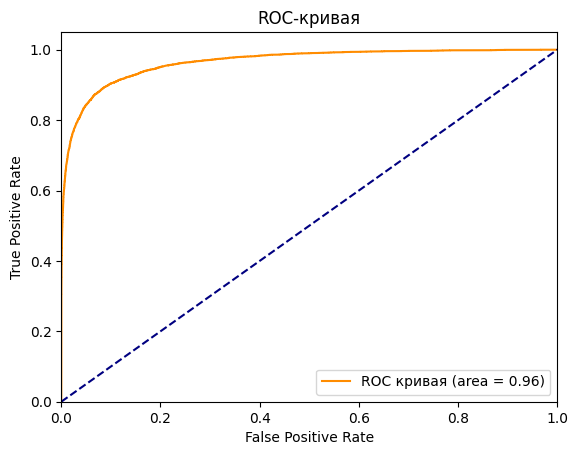

In [38]:

# получаем предказания
lr_probs = best_model.predict_proba(tf_idf_test)

# сохраняем вероятности только для положительного исхода
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(target_test, lr_probs)
print('Логистическая регрессия: ROC AUC = %.3f' % (lr_auc))
print('f1: = %.3f' % f1_score(target_test, predict_best))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()


## Выводы

Для оценки токсичности комментариев я могу предложить использовать модель логистической регрессии с параметрами C=10, penalty='l2', solver='lbfgs' и балансом весов 1:8 (class_weight={0 : 1, 1: 8}).